<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

Uncomment and execute the following code cell to install the dependencies:

In [1]:
# pip install -r https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/requirements.txt

Uncomment and execute the following code cell to install the PyTorch nightly dependency if you want to run the FlexAttention benchmarks (this is required because FlexAttention is not yet included in the latest PyTorch release):

In [2]:
# pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121 -U

# Comparing Efficient Multi-Head Attention Implementations

This code notebook compares different ways to implement causal multi-head attention used in decoder-style LLMs like GPT, Llama, etc.

In [1]:
import torch

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")

batch_size = 8
context_len = 1024
embed_dim = 768
embeddings = torch.randn((batch_size, context_len, embed_dim), device=device)

PyTorch version: 2.1.1+cu121


<br>
&nbsp;

## 1) CausalAttention MHA wrapper class from chapter 3

In [2]:
import torch.nn as nn

class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)  # New
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))  # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape  # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)  # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)  # New

        context_vec = attn_weights @ values
        return context_vec


class Ch03_MHA_Wrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )
        self.out_proj = nn.Linear(d_out*num_heads, d_out*num_heads)

    def forward(self, x):
        context_vec = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.out_proj(context_vec)


mha_ch03_wrapper = Ch03_MHA_Wrapper(
    d_in=embed_dim,
    d_out=embed_dim//12,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03_wrapper(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 2) The multi-head attention class from chapter 3

In [3]:
class Ch03_MHA(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


mha_ch03 = Ch03_MHA(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 3) An alternative multi-head attention with combined weights

- The code for the `MultiHeadAttentionCombinedQKV` class below is based on code that was kindly shared by [Rayed Bin Wahed](https://github.com/rasbt/LLMs-from-scratch/discussions/51)
- The main difference between the `MultiHeadAttentionCombinedQKV` class and the `MultiHeadAttention` class used in chapter 3 is that `MultiHeadAttentionCombinedQKV` uses a single weight matrix, `self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)` instead of separate weight matrices:

  - `self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)`
  - `self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)`
  - `self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)`

- Here, `self.qkv` combines all three weight matrices `self.W_query`, `self.W_key`, and `self.W_value` to carry out the query, key, and value computation in a single step
- Using `q, k, v = qkv.unbind(0)`, we obtain the individual query, key, and value tensors, which are then used similarly to the query, key, and value tensors in the `MultiHeadAttention` class in chapter 3

In [4]:
import torch.nn as nn


class MultiHeadAttentionCombinedQKV(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_head, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        # (b, num_heads, num_tokens, head_dim) --> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(-2, -1)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**-0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # (b, num_heads, num_tokens, num_tokens) --> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values

        # (b, num_heads, num_tokens, head_dim) --> (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)

        # (b, num_tokens, num_heads, head_dim) --> (b, num_tokens, embed_dim)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)

        context_vec = self.proj(context_vec)

        return context_vec


mha_combined_qkv = MultiHeadAttentionCombinedQKV(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_combined_qkv(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 4) Multi-head attention with Einsum

- Implementing multi-head attention using Einstein summation via [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html)

In [6]:
import math


class MHAEinsum(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # Initialize parameters for Q, K, V
        self.W_query = nn.Parameter(torch.randn(d_out, d_in))
        self.W_key = nn.Parameter(torch.randn(d_out, d_in))
        self.W_value = nn.Parameter(torch.randn(d_out, d_in))

        if qkv_bias:
            self.bias_q = nn.Parameter(torch.zeros(d_out))
            self.bias_k = nn.Parameter(torch.zeros(d_out))
            self.bias_v = nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter("bias_q", None)
            self.register_parameter("bias_k", None)
            self.register_parameter("bias_v", None)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

        # Initialize parameters
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_query, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_key, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_value, a=math.sqrt(5))
        if self.bias_q is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_query)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_q, -bound, bound)
            nn.init.uniform_(self.bias_k, -bound, bound)
            nn.init.uniform_(self.bias_v, -bound, bound)

    def forward(self, x):
        b, n, _ = x.shape

        # Calculate Q, K, V using einsum, first perform linear transformations
        Q = torch.einsum("bnd,di->bni", x, self.W_query)
        K = torch.einsum("bnd,di->bni", x, self.W_key)
        V = torch.einsum("bnd,di->bni", x, self.W_value)

        # Add biases if they are used
        if self.bias_q is not None:
            Q += self.bias_q
            K += self.bias_k
            V += self.bias_v

        # Reshape for multi-head attention
        Q = Q.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.einsum("bhnd,bhmd->bhnm", Q, K) / (self.head_dim ** 0.5)

        # Apply mask
        mask = self.mask[:n, :n].unsqueeze(0).unsqueeze(1).expand(b, self.num_heads, n, n)
        scores = scores.masked_fill(mask.bool(), -torch.inf)

        # Softmax and dropout
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Aggregate the attended context vectors
        context_vec = torch.einsum("bhnm,bhmd->bhnd", attn_weights, V)

        # Combine heads and project the output
        context_vec = context_vec.transpose(1, 2).reshape(b, n, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


mha_einsum = MHAEinsum(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_einsum(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 5) Multi-head attention with PyTorch's scaled dot product attention and FlashAttention

- The implementation below uses PyTorch's [`scaled_dot_product_attention`](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) function, which implements a memory-optimized version of self-attention called [FlashAttention](https://arxiv.org/abs/2205.14135)

In [7]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec

In [8]:
mha_pytorch_scaled = MHAPyTorchScaledDotProduct(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_scaled(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 6) PyTorch's scaled dot product attention without FlashAttention

- This is similar to above, except that we disable FlashAttention by passing an explicit causal mask

In [9]:
class MHAPyTorchSDPAWithoutFlash(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=attn_mask, dropout_p=use_dropout, is_causal=False)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec

In [10]:
mha_pytorch_sdpa_no_flash = MHAPyTorchSDPAWithoutFlash(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_sdpa_no_flash(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 7) Using PyTorch's torch.nn.MultiheadAttention

- Below, we use PyTorch's [torch.nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) implementation

In [11]:
import torch.nn as nn


class MHAPyTorchClass(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False, need_weights=True):
        super().__init__()

        self.context_length = context_length
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            batch_first=True,
        )

        self.need_weights = need_weights
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, _ = x.shape

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        # attn_mask broadcasting will handle batch_size dimension implicitly
        attn_output, _ = self.multihead_attn(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )

        output = self.proj(attn_output)

        return output


mha_pytorch_class_default = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_class_default(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 8) Using PyTorch's torch.nn.MultiheadAttention with `scaled_dot_product_attention`

- Set `need_weights` (default `True`) to need_weights=False so that `MultiheadAttention` uses `scaled_dot_product_attention` [according to the documentation](https://github.com/pytorch/pytorch/blob/71d020262793542974cf13b30f2a9099773f015c/torch/nn/modules/activation.py#L1096)

>  need_weights: If specified, returns ``attn_output_weights`` in addition to ``attn_outputs``.
            Set ``need_weights=False`` to use the optimized ``scaled_dot_product_attention``
            and achieve the best performance for MHA.
            Default: ``True``.

In [12]:
mha_pytorch_class_noweights = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False,
    need_weights=False # NEW!
).to(device)

out = mha_pytorch_class_noweights(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 9) Using PyTorch's FlexAttention

- See [FlexAttention: The Flexibility of PyTorch with the Performance of FlashAttention](https://pytorch.org/blog/flexattention/) to learn more about FlexAttention
- This is currently only supported in PyTorch 2.5 (nightly), which you can install on a CPU machine via

    ```bash
    pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu -U
    ```

- To install PyTorch nighly on a GPU machine, use the following (for more information, also see the installation menu on [pytorch.org](https://pytorch.org/))

    ```bash
    pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121 -U
    ```

In [13]:
from packaging.version import parse as parse_version

def normalize_version(version):
    parsed_version = parse_version(version)
    return parse_version(f"{parsed_version.major}.{parsed_version.minor}.{parsed_version.micro}")

current_version = normalize_version(torch.__version__)
MIN_TORCH_VERSION = "2.5.0"
required_version = parse_version(MIN_TORCH_VERSION)

In [14]:
if current_version >= required_version:
    from torch.nn.attention.flex_attention import flex_attention, create_block_mask


def causal(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx


class MHAPyTorchFlexAttention(nn.Module):

    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        # self.register_buffer("block_mask", create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length))
        # `create_block_mask` function does not support buffers, yet
        self.block_mask = create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length)


    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.context_length >= num_tokens:
            attn_mask = self.block_mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.block_mask[:self.context_length, :self.context_length]

        context_vec = flex_attention(queries, keys, values, block_mask=attn_mask)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec

In [15]:
if current_version >= required_version and torch.cuda.is_available():

    mha_pytorch_flex = MHAPyTorchFlexAttention(
        d_in=embed_dim,
        d_out=embed_dim,
        context_length=context_len,
        dropout=0.0,
        num_heads=12,
        qkv_bias=False
    ).to(device)

    out = mha_pytorch_flex(embeddings)
    print(out.shape)

<br>
&nbsp;

## Quick speed comparison (M3 Macbook Air CPU)

In [16]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.1.1+cu121
Running on cuda


In [17]:
## 1) CausalAttention MHA wrapper class from chapter 3
%timeit mha_ch03_wrapper(embeddings)

8.72 ms ± 4.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
## 2) The multi-head attention class from chapter 3
%timeit mha_ch03(embeddings)

7.05 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
## 3) An alternative multi-head attention with combined weights
%timeit mha_combined_qkv(embeddings)

8.02 ms ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
## 4) Multi-head attention using Einstein summation
%timeit mha_einsum(embeddings)

8.44 ms ± 4.62 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
## 5) Multi-head attention with PyTorch's scaled dot product attention
%timeit mha_pytorch_scaled(embeddings)

3.86 ms ± 5.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
## 6) PyTorch's scaled dot product attention without FlashAttention
%timeit mha_pytorch_sdpa_no_flash(embeddings)

6.45 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
## 7) Using PyTorch's torch.nn.MultiheadAttention
%timeit mha_pytorch_class_default(embeddings)

7.61 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
## 8) Using PyTorch's torch.nn.MultiheadAttention disabling `need_weights`
%timeit mha_pytorch_class_noweights(embeddings)

7.24 ms ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
## 9) Using PyTorch's FlexAttention

# Requires PyTorch 2.5.0 or newer and currently only supports CUDA PyTorch
%timeit mha_pytorch_flex(embeddings)

NameError: name 'mha_pytorch_flex' is not defined

<br>
&nbsp;

## Quick speed comparison (Nvidia A100 GPU)

In [26]:
# Enable tensor cores
torch.set_float32_matmul_precision("high")

In [27]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.1.1+cu121
Running on cuda


In [28]:
## 1) CausalAttention MHA wrapper class from chapter 3
%timeit mha_ch03_wrapper(embeddings)

6.3 ms ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
## 2) The multi-head attention class from chapter 3
%timeit mha_ch03(embeddings)

5.7 ms ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
## 3) An alternative multi-head attention with combined weights
%timeit mha_combined_qkv(embeddings)

6.57 ms ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
## 4) Multi-head attention using Einstein summation
%timeit mha_einsum(embeddings)

7.19 ms ± 9.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
## 5) Multi-head attention with PyTorch's scaled dot product attention
%timeit mha_pytorch_scaled(embeddings)

3.03 ms ± 3.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
## 6) PyTorch's scaled dot product attention without FlashAttention
%timeit mha_pytorch_sdpa_no_flash(embeddings)

5.66 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
## 7) Using PyTorch's torch.nn.MultiheadAttention
%timeit mha_pytorch_class_default(embeddings)

6.18 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
## 8) Using PyTorch's torch.nn.MultiheadAttention disabling `need_weights`
%timeit mha_pytorch_class_noweights(embeddings)

6.43 ms ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
## 9) Using PyTorch's FlexAttention

# Requires PyTorch 2.5.0 or newer
%timeit mha_pytorch_flex(embeddings)

NameError: name 'mha_pytorch_flex' is not defined

<br>
&nbsp;


# Visualizations

In [37]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.1.1+cu121
Running on cuda


In [38]:
functions = {
    "1) MHA wrapper class": mha_ch03_wrapper,
    "2) MHA Ch03": mha_ch03,
    "3) MHA with combined QKV weights": mha_combined_qkv,
    "4) MHA with Einsum": mha_einsum,
    "5) MHA with PyTorch scaled_dot_product_attention": mha_pytorch_scaled,
    "6) PyTorch's SDPA, no FlashAttention": mha_pytorch_sdpa_no_flash,
    "7) PyTorch MHA class defaults": mha_pytorch_class_default,
    "8) PyTorch MHA with need_weights=False": mha_pytorch_class_noweights
    }

if current_version >= required_version:
    functions["8) PyTorch's FlexAttention"] =  mha_pytorch_flex

In [39]:
import matplotlib.pyplot as plt

# Customize further for dark mode aesthetics
plt.rcParams["figure.facecolor"] = "#121212"
plt.rcParams["axes.facecolor"] = "#121212"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["text.color"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["grid.color"] = "#444444"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8

def plot_execution_times(functions, execution_means, execution_stds, filename):

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(functions.keys(), execution_means, yerr=execution_stds, capsize=5, error_kw={'ecolor': 'grey'})

    plt.ylabel("Execution time (ms)")
    plt.xticks(rotation=45, ha="right")

    # Calculate new ylim with a margin
    max_execution_time = max(execution_means)
    upper_ylim = max_execution_time + 0.4 * max_execution_time  # Adding a 40% margin
    plt.ylim(0, upper_ylim)

    # Annotate bars with execution times
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha="center", va="bottom")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

## Speed comparison (Nvidia A100 GPU) with warmup (forward pass only)

In [40]:
# CUDA benchmark code shared by Andrei Aksionov
# and based on code from
# https://github.com/cuda-mode/lectures/blob/main/lecture1/pytorch_square.py

import numpy as np

def time_pytorch_function(func, *input, num_repeats=1_000):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        func(*input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        func(*input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

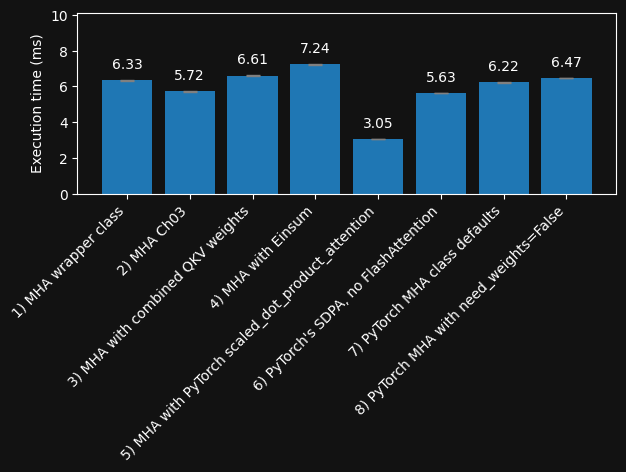

In [41]:
execution_stats = [time_pytorch_function(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="1_forward-only.pdf")

<br>
&nbsp;


## Speed comparison (Nvidia A100 GPU) with warmup (forward and backward pass)

In [42]:
def forward_backward(func, embeddings):
    if embeddings.grad is not None:
        embeddings.grad.zero_()

    output = func(embeddings)
    loss = output.sum()
    loss.backward()


def time_pytorch_function_forward_backward(func, *input, num_repeats = 1_000):
    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        forward_backward(func, *input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        forward_backward(func, *input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

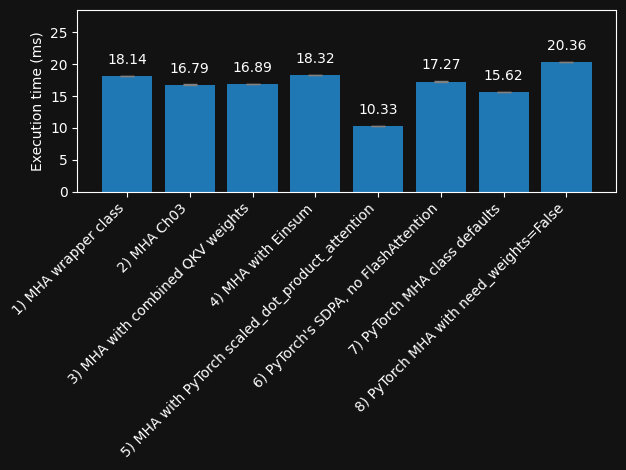

In [43]:
execution_stats = [time_pytorch_function_forward_backward(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="2_forward-and-backward.pdf")

<br>
&nbsp;


## Speed comparison (Nvidia A100 GPU) with warmup and compilation (forward and backward pass)

In [44]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

def prepare_function(fn):
    fn = torch.compile(fn)
    return fn

/home/anaconda3/envs/risk_newtorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


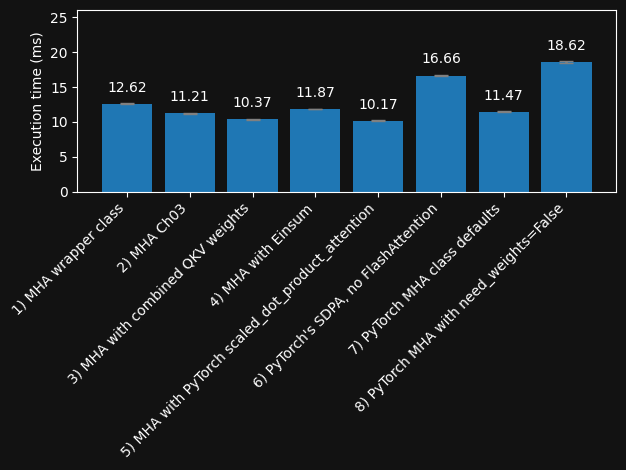

In [45]:
execution_stats = [time_pytorch_function_forward_backward(prepare_function(fn), embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="3_forward-and-backward-compiled.pdf")